In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()


# reflect the tables

Base.prepare(engine, reflect=True)


In [7]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# list table names using inspector
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [9]:
#Figure out database keys for both tables
print('columns of measurement table:')
columns = inspector.get_columns('measurement')
for column in columns:
     print(column["name"], column["type"])
print('                  ')
print('columns of station table:')
columns = inspector.get_columns('station')
for column in columns:
     print(column["name"], column["type"])


columns of measurement table:
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
                  
columns of station table:
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [10]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [12]:
# Find the most recent date in the data set.

mostRecentDate=max(session.query(Measurement.date))[0]
print(mostRecentDate)

2017-08-23


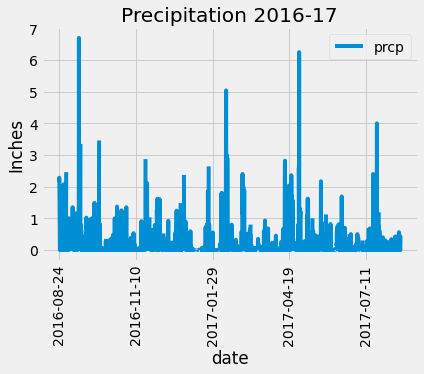

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 


# Calculate the date one year from the last date in data set.
yearBackFromRecent=dt.datetime.strptime(mostRecentDate,"%Y-%m-%d")-dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
prcp_scores=session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > yearBackFromRecent)

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_scores_df = pd.DataFrame(prcp_scores, columns=['date', 'prcp' ])
prcp_scores_df.set_index('date', inplace = True)
# Sort the dataframe by date

prcp_scores_df=prcp_scores_df.sort_values(by="date")
# Use Pandas Plotting with Matplotlib to plot the data
prcp_scores_df.plot(rot=90,title="Precipitation 2016-17")
plt.ylabel("Inches")
plt.show()


In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_scores_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [15]:
# Design a query to calculate the total number stations in the dataset
session.query(func.count(Station.id)).all()

[(9,)]

In [16]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
#session.query(Measurement.station).all()
session.query(Measurement.station,func.count(Measurement.station)).\
group_by(Measurement.station).\
order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [20]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
session.query(Measurement.station,\
              func.min(Measurement.tobs),\
              func.max(Measurement.tobs),\
              func.avg(Measurement.tobs)).\
filter(Measurement.station == 'USC00519281').all()

[('USC00519281', 54.0, 85.0, 71.66378066378067)]

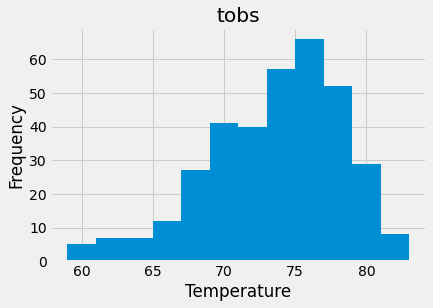

In [30]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this 
# station and plot the results as a histogram
tobs_USC00519281=session.query(Measurement.date,Measurement.tobs).\
    filter(Measurement.date > yearBackFromRecent).\
filter(Measurement.station == 'USC00519281').all()
tobs_USC00519281_df = pd.DataFrame(tobs_USC00519281,\
                                   columns=['date', 'tobs' ])
tobs_USC00519281_df.set_index('date', inplace = True)
tobs_USC00519281_df=tobs_USC00519281_df.sort_values(by="date")
tobs_USC00519281_df.hist(column='tobs', bins=12)
plt.xlabel('Temperature')
plt.ylabel('Frequency');

# Close session

In [31]:
# Close Session
session.close()